# CS 410 Fall 2019 - Final Project

## Movie Tweets Sentiment Analysis


## Installing required modules



<a id='textblob_install'></a>

### Install TextBlob

**To install textblob run:**

> `conda install -c conda-forge textblob`

**Or:**

> `pip install textblob`


### Install vaderSentiment

**To install vaderSentiment run:**

> `conda install -c conda-forge vaderSentiment`

**Or:**

> `pip install vaderSentiment`


### Install nltk

**To install nltk run:**

> `conda install -c conda-forge nltk`

**Or:**

> `pip install nltk`


### Installing other data science modules
> `pip install tweepy`

> `pip install wordcloud`

> `pip install pandas`

> `pip install seaborn`



Below is a command to install all required Module. If you have installed them before you don't need to run this **pip install**.
However, if not installed, please uncomment the below block and run the pip install command.
In case you run into environment permission related errors then suffix below installation command with `--user`

In [1]:
#!pip install tweepy textblob wordcloud pandas seaborn vaderSentiment nltk

##  NLTK module and punkt download
In order to tokenize and using stopwords module, we would need to download **punkt** and **averaged_perceptron_tagger** from nltk module.

**Similar to above, if you have never downloaded it before please uncomment the statement before running below block**

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.tag import pos_tag
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [3]:
import tweepy
from tweepy import OAuthHandler,API, TweepError
from textblob import TextBlob 
from string import punctuation 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
from string import punctuation
import csv
import json


## Brief description about VADER and TEXTBLOB

VADER(Valence Aware Dictionary and sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool. Each words in the lexicon is rated whether it is positive or negative. For eg: Though good and best both are positive but best's intensity is higher then good, similarly, good and GOOD, GOOD will get more weightage then simply good. Also, vader is also capable to weigh based emotions on emojis feelings. Vader results are based on four sentiment metrics as positive, negative, neutral and compound. Compound score is the sum of all of the lexicon rating whose value can range anywhere between -1 and 1. To read more about the vader scring, you can refer to : 
https://github.com/cjhutto/vaderSentiment#about-the-scoring

TEXTBLOB is a NLTK and Pattern based natural language processing and sentiment analysis library. It determines sentiment metrics on two properties, polarity and subjectivity. Polarity is the sentiment which lies between -1 and 1 where 1 means positive and -1 means a negative where anything greater than 0 is positive and below 0 is negative.. The subjectivity is a measure of the sentiment being objective to subjective, and goes from 0 to 1. To read more about textblob, you can refer to :
https://textblob.readthedocs.io/en/dev/



## Default Functions

Below we have few functions to use later in our analysis.

    1. function to clean a tweet data
       This function will remove urls, unwanted characters like punctuation, RT reference etc.
    
    2. function to remove stop words in tweets
       In this function we first tokenize tweet text using wordpunct_tokenize which uses regex pattern '\w+|\$[\d\.]+|\S+'
       internally and then return remaining words in text after filtering stop words.

In [4]:
def clean_tweet(tweet):
        #removing urls(http:..)
        tweet = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', tweet)
                
        #removing RT refences from Tweets
        tweet=re.sub(r"@[^:/s]*",'',tweet)
        tweet=re.sub(r"RT",'',tweet)

        #removing any other punctuation or unwanted character
        tweet=re.sub(r"[.,;:$&*|?'-]",'',tweet)
        
        #removing unwanted x** characters
        tweet = re.sub(r'(\\x(.){2})', '',tweet)

        return tweet.lower()

def remove_sw(text,sw):
    tokens = wordpunct_tokenize(text)
    clean_tokens = [i.lower() for i in tokens if i.lower() not in sw]
    return " ".join(clean_tokens)
    

    


## TwitterClient class definition

Below we are defining a Twitter class object, which will help us creating objects to connect to Twitter API and then fethcing
the tweets based on search . Note that we are using standard search API which allows return max of 100 tweets per page. Because we are using user authentication to connect to twitter api, we have to abide by maximum of 180 requests every 15 mins. As per twitter documentation, twitter api neither index all tweets or make it available through search interface. Refer to twitter documentation for more details: https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets

In TwitterClient class we are doing user authentication using api key and secret. Once authentication is done successfully, then we perfom twitter search. Parameter wait_on_rate_limit=True ensure that if max request is reached within 15 mins interval then the API will not request any further and will wait for 15 mins to elapse.

In [5]:
    
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for extracting Tweets. 
    '''
    def __init__(self, api_key): 
        ''' 
        Class constructor or initialization method. 
        '''
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])
        
        # keys and tokens from the Twitter Dev Console 
        consumer_key = api_key['consumer_key']
        consumer_secret =  api_key['consumer_secret']
        access_token = api_key['access_token']
        access_token_secret = api_key['access_token_secret']

        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = API(self.auth,wait_on_rate_limit=True) 
        except: 
            print("Error: Authentication Failed") 

    def get_tweets(self, query, tweets_count): 
        ''' 
        Function to fetch tweets.
        Refer to link: https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets
        General Twitter client can search tweets which are less than 7 days.  
        '''
        if fetch_latest == True:
            tweets = []
            
            for tweet in tweepy.Cursor(self.api.search,
                                       q=query,
                                       since=date_range['since'],
                                       until = date_range['until'],
                                       show_user = True).items(tweets_count):
                tweets.append(tweet)
        return tweets

## Reading Tweets

We provide two methods to read/extract tweets for analysis.

**1. Searching tweets using Twitter API**

**2. Loading Tweets from stored CSV**

###  1. Searching tweets using Twitter API

Below we have setup an **API dict** variable with various tokens and consumer keys. It can be replaced with the API key generated from Twitter API access. We have also setup the movie name for our Analysis in **movie** variable

We are now going to create an object of Twitter API class. After fetching the Tweets using searchapi. We will convert the extracted data into a dataframe. 

Note that tweets csv file provided along with this report are generated using below commented code. You can set value of 'tweets_count' of your choice which basically gives number of tweeets to fetch.

### <font color=red>NOTE : We have commented below block as we can use CSV file provided with the code for the analysis</font>

### To unlock please select the block and press Ctrl +A , Ctrl + /

In [6]:

# #Initializing the parameters
# api_key ={'consumer_key' : 'set_your_consumer_key',
# 'consumer_secret' : 'set_your_consumer_secret',
# 'access_token': 'set_your_access_token',
# 'access_token_secret' : 'set_your_access_token_secret'}

# days_to_subtract = 10
# today_date = datetime.today()
# until = str(today_date.year)+'-'+str(today_date.month)+'-'+str(today_date.day)
# since_date = today_date - timedelta(days=days_to_subtract)
# since = str(since_date.year)+'-'+str(since_date.month)+'-'+str(since_date.day)

# date_range ={'since' : since,
#              'until' : until
#             }

# movie="#Irishman"
# tweets_count = 5000
# fetch_latest = True

# #Creating TwitterClient Object
# client_api = TwitterClient(api_key) 

# #Fetching Tweets and avoiding retweets 
# query_text = movie + " -filter:retweets"
# if fetch_latest:
#     tweets = client_api.get_tweets(query = query_text, tweets_count = tweets_count)
    
#     #extracting the required columns
#     tweet_extract= [[tweet.text, tweet.created_at, tweet.user.followers_count,  tweet.user.statuses_count , tweet.retweet_count, tweet.favorite_count, tweet.lang] for tweet in tweets]
    
#     #converting Tweets to Pandas Dataframe
#     tweet_data = pd.DataFrame(data=tweet_extract,columns=['text','created_at', "user_follower_counts", "user_status_counts" , 'retweet_count','favorite_count','lang'])
#     tweet_data = tweet_data[tweet_data.lang=="en"]
#     tweet_data.to_csv("tweets.csv")


###  2. Loading tweets from stored CSV

Here we are going to use a preloaded csv file that contains the tweets extracts usnig #Irishman to explore the already extracted tweets. 

#### Note: The below menitoned Tweet extracts are available for Testing purposes.

tweets.csv - contains tweet extracts using #Irishman.

tweets_FORDvFERRARI.csv - contains tweet extracts using #FORDvFERRARI.

tweets_KnivesOutFilm.csv - contains tweet extracts using #KnivesOutFilm.

In [7]:
tweet_data = pd.read_csv("tweets.csv",sep = ',')    

### Tweet clean-up

Using our predefined functions we are going to clean tweets.

In [8]:
tweet_data['text']= tweet_data['text'].map(lambda text: clean_tweet(text))

## Exploratory text analysis of tweets 

In below exploration, we want to analyze text of some sample tweets and analyze various functionalities of text parsing libraries. As we have created text of tweets, below we are going to analyze the first tweet from the list. Which has following text

In [9]:
text = "".join(tweet_data.text)
print(text)

the #irishman was really good i dont like the don rickles impersonationhappy holidays
from all of your irishman friends!

#theirishman #theirishmanfilm #irishman #theirishmemes a lot of chatter about marriage story  official trailer  netflix  hmmm i’m more of an… #irishman awful#irishman good movie with hollywood best actors  i want to know who killed jimmy hoffa and where is the body 💁🏻‍♀️i dont know why but the image of robert deniro and al pacino having a sleepover in the #irishman brings me great joysmma notorious by adelitas way thats the next walkout song for you my brother you are welcome! my fe… s i call it the “better hurry and watch that movie because we will spend 3 days… my bf came up with this meme and i just had to make it 😅 #irishman #babyyodameme martin scorsese 👏👏 #irishmansunday dinner while watching the #irishman loving the movie and references im about three days into #irishman and im not even sure i understand whats going oni sat through all 3 1/2 hours of the #iri

### Sentence and Word tokenization of the tweets

In [10]:
#Tokenize text using sent_tokenize function
sentences = sent_tokenize(text)
sentences

['the #irishman was really good i dont like the don rickles impersonationhappy holidays\nfrom all of your irishman friends!',
 '#theirishman #theirishmanfilm #irishman #theirishmemes a lot of chatter about marriage story  official trailer  netflix  hmmm i’m more of an… #irishman awful#irishman good movie with hollywood best actors  i want to know who killed jimmy hoffa and where is the body 💁🏻\u200d♀️i dont know why but the image of robert deniro and al pacino having a sleepover in the #irishman brings me great joysmma notorious by adelitas way thats the next walkout song for you my brother you are welcome!',
 'my fe… s i call it the “better hurry and watch that movie because we will spend 3 days… my bf came up with this meme and i just had to make it 😅 #irishman #babyyodameme martin scorsese 👏👏 #irishmansunday dinner while watching the #irishman loving the movie and references im about three days into #irishman and im not even sure i understand whats going oni sat through all 3 1/2 ho

### Sample distribution of the words

Below graph shows the sample distribution of the words. As we can see the left side of the graphs represents high term frequency words, which are mostly Stop words and name of movie we have used to search the tweet. This sample distribution can be used to remove the words from our tweets for analysis.

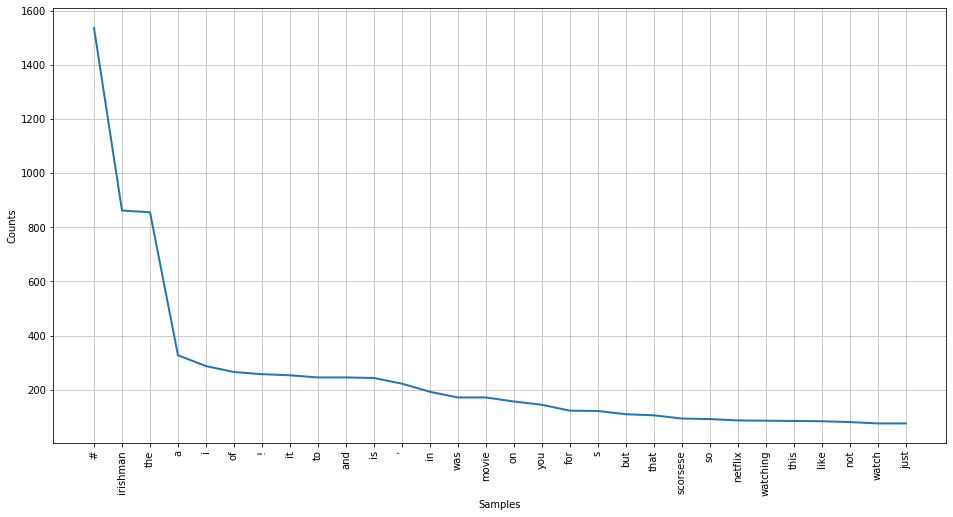

In [11]:
words = word_tokenize(text)
word_frequencies = FreqDist(words)
sorted_counts = sorted(word_frequencies.items() , key = lambda x: x[1] ,
                       reverse = True)

plt.figure(figsize=(16,8)) 
FreqDist(word_frequencies).plot(30,cumulative=False)
plt.show()

###  Part of Speech tagging of words.

Here we are going to use part of speech tagging library to show the tagging of all words.

**Output is tuple pairings of tokens with their POS tags.**

#### Some of POS tags: 
WP: wh-pronoun ("who", "what")  
VBZ: verb, 3rd person sing. present ("takes")  
VBG: verb, gerund/present participle ("taking")  
TO: to ("to go", "to him")   
DT: determiner ("the", "this")  
NN: noun, singular or mass ("door")  

All tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [12]:
#Tokenize text
tokens = word_tokenize(text.lower())
#Pass tokens into pos_tag function
pos_tag(tokens)

[('the', 'DT'),
 ('#', '#'),
 ('irishman', 'NN'),
 ('was', 'VBD'),
 ('really', 'RB'),
 ('good', 'JJ'),
 ('i', 'NN'),
 ('dont', 'VBP'),
 ('like', 'IN'),
 ('the', 'DT'),
 ('don', 'NN'),
 ('rickles', 'VBZ'),
 ('impersonationhappy', 'JJ'),
 ('holidays', 'NNS'),
 ('from', 'IN'),
 ('all', 'DT'),
 ('of', 'IN'),
 ('your', 'PRP$'),
 ('irishman', 'JJ'),
 ('friends', 'NNS'),
 ('!', '.'),
 ('#', '#'),
 ('theirishman', 'JJ'),
 ('#', '#'),
 ('theirishmanfilm', 'JJ'),
 ('#', '#'),
 ('irishman', 'JJ'),
 ('#', '#'),
 ('theirishmemes', 'VBZ'),
 ('a', 'DT'),
 ('lot', 'NN'),
 ('of', 'IN'),
 ('chatter', 'NN'),
 ('about', 'IN'),
 ('marriage', 'NN'),
 ('story', 'NN'),
 ('official', 'JJ'),
 ('trailer', 'NN'),
 ('netflix', 'NN'),
 ('hmmm', 'NN'),
 ('i', 'NN'),
 ('’', 'VBP'),
 ('m', 'RB'),
 ('more', 'JJR'),
 ('of', 'IN'),
 ('an…', 'JJ'),
 ('#', '#'),
 ('irishman', 'JJ'),
 ('awful', 'JJ'),
 ('#', '#'),
 ('irishman', 'JJ'),
 ('good', 'JJ'),
 ('movie', 'NN'),
 ('with', 'IN'),
 ('hollywood', 'NN'),
 ('best', 'JJS')

### Removing stop words from the text

Below we are going to remove stop words from tweet and then analyze the tweets token distribution again

In [13]:
## creating stop words, adding top 5 frequent terms to avoid movie names in analysis
sw = stopwords.words("english")
sw += punctuation
sw += list(zip(*sorted_counts))[0][:5]

In [14]:
tweet_data['text']= tweet_data['text'].map(lambda text: remove_sw(text,sw))

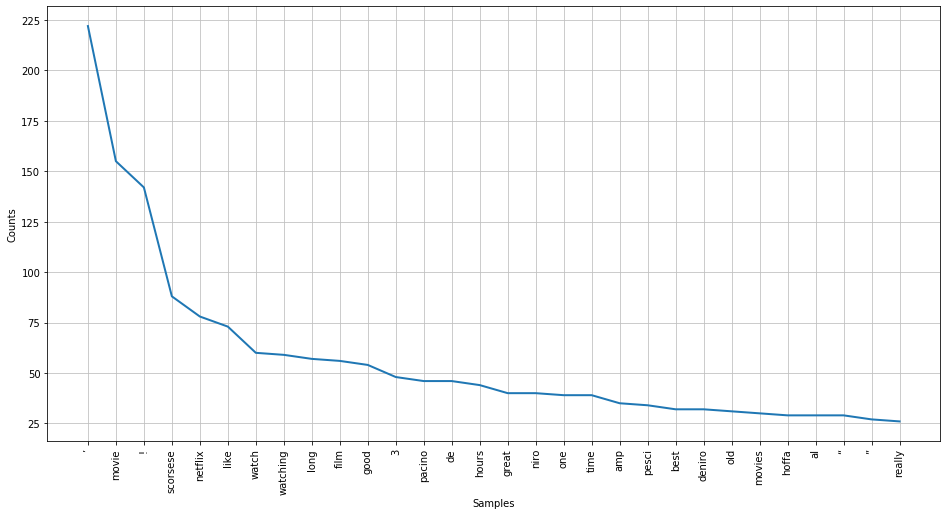

In [15]:
text = "".join(tweet_data.text)
plt.figure(figsize=(16,8)) 
FreqDist(word_tokenize(text)).plot(30,cumulative=False)
plt.show()

### Sentiment analysis of  individual tweets

We will use TextBlob sentiment polarity to run sentiment analysis on the extracted tweets. This will provide us a score for each tweet. We can later use this score to categorize tweets into positive and negative tweets

In [16]:
tweet_data['textblob_sentiment_score'] = tweet_data['text'].map(lambda text: TextBlob(text).sentiment.polarity)
vader_analyzer = SentimentIntensityAnalyzer()
tweet_data['vader_sentiment_score'] = tweet_data['text'].map(lambda text: vader_analyzer.polarity_scores(text)['compound'])

Setting sentiment of tweets based on score.

Based on score, we can now mark a tweet as Postive, Negative or Neutral
This sentiment categorization will help us run the different EDA.
In the end, we can take a look at top 5 rows of dataset to verify.

In [17]:
tweet_data.loc[tweet_data.textblob_sentiment_score < 0, 'textblob_sentiment'] = 'Negative'
tweet_data.loc[tweet_data.textblob_sentiment_score > 0, 'textblob_sentiment'] = 'Positive' 
tweet_data.loc[tweet_data.textblob_sentiment_score == 0, 'textblob_sentiment'] = 'Neutral'
tweet_data.loc[tweet_data.vader_sentiment_score < 0, 'vader_sentiment'] = 'Negative'
tweet_data.loc[tweet_data.vader_sentiment_score > 0, 'vader_sentiment'] = 'Positive' 
tweet_data.loc[tweet_data.vader_sentiment_score == 0, 'vader_sentiment'] = 'Neutral'

In [18]:
tweet_data.head()

Unnamed: 0                                               text  \
0           1        really good dont like rickles impersonation   
1           3  happy holidays friends theirishman theirishman...   
2           6  lot chatter marriage story official trailer ne...   
3           7                                              awful   
4           8  good movie hollywood best actors want know kil...   

            created_at  user_follower_counts  user_status_counts  \
0  2019-12-08 23:41:42                   927               85172   
1  2019-12-08 23:39:53                    76                4690   
2  2019-12-08 23:07:14                   360                2493   
3  2019-12-08 22:49:17                     4                 201   
4  2019-12-08 22:45:48                    52                2387   

   retweet_count  favorite_count lang  textblob_sentiment_score  \
0              0               0   en                       0.7   
1              0               0   en                       0.8   
2              0               0   en                       0.0   
3              0               0   en                      -1.0   
4              0               0   en                       0.5   

   vader_sentiment_score textblob_sentiment vader_sentiment  
0                 0.2070           Positive        Positive  
1                 0.8555           Positive        Positive  
2                 0.0000            Neutral         Neutral  
3                -0.4588           Negative        Negative  
4                 0.7269           Positive        Positive

# Checking distribution of sentiments

Below we can see the sentiment distribution of various tweets.
First we are going to see normalize distribution of various tweets and then we will see values on chart


In [19]:
tweet_data.textblob_sentiment.value_counts(normalize=True)

Positive    0.435875
Neutral     0.408146
Negative    0.155979
Name: textblob_sentiment, dtype: float64

In [20]:
tweet_data.vader_sentiment.value_counts(normalize=True)
#tweet_data.to_csv("tweets_extract_with_values.csv")

Positive    0.500000
Neutral     0.341421
Negative    0.158579
Name: vader_sentiment, dtype: float64

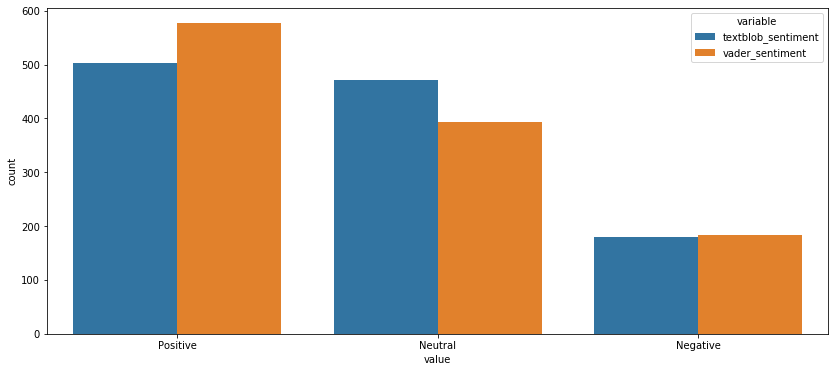

In [21]:
df_sentiment = tweet_data[['textblob_sentiment','vader_sentiment']]
plt.figure(figsize=(14,6))
sns.countplot(x="value", hue="variable", data=pd.melt(df_sentiment))
#sns.relplot(x="Index", y="textblob_sentiment_score", hue="textblob_sentiment", data=tweet_data);

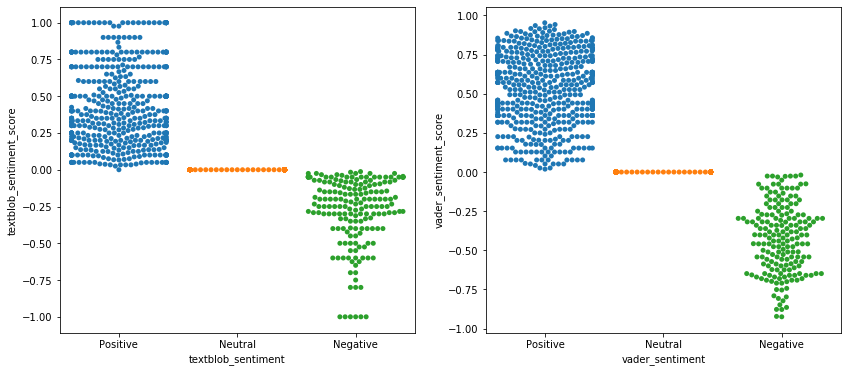

In [22]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(14,6))
sns.swarmplot(x="textblob_sentiment", y="textblob_sentiment_score", data=tweet_data , ax=ax1);
sns.swarmplot(x="vader_sentiment", y="vader_sentiment_score", data=tweet_data, ax=ax2);

### Explanation of graphs
After carefully analysing each individual tweets, we can clearly see for the dataset the positive sentiment are much larger than negative sentiments. There is a significant number of neutral results.


### Comparision of Vader & TextBlob

As we can see for Vader and TextBlob provides similar kind of results. However, vader is more aggresive in identifying positive sentiments compared to TextBlob


## Analyzing positive tweets

In this section we will do some exploratory data analysis on positive tweets.

### Word Cloud of positive Tweets

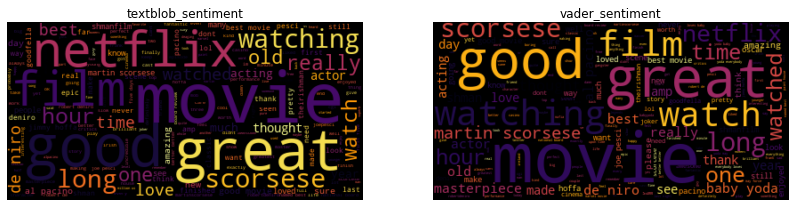

In [23]:
f, axarr = plt.subplots(1,2,figsize=(14,6))
ptweets= tweet_data[tweet_data.textblob_sentiment=='Positive'].text
wordcloud = WordCloud(background_color= 'black', colormap='inferno').generate(",".join(ptweets))
axarr[0].imshow(wordcloud, interpolation='bilinear')
axarr[0].axis("off")
axarr[0].title.set_text('textblob_sentiment')

ptweets= tweet_data[tweet_data.vader_sentiment=='Positive'].text
wordcloud = WordCloud(background_color= 'black', colormap='inferno').generate(",".join(ptweets))
axarr[1].imshow(wordcloud, interpolation='bilinear')
axarr[1].axis("off")
axarr[1].title.set_text('vader_sentiment')

### Retweet & Fav counts of Positive tweets

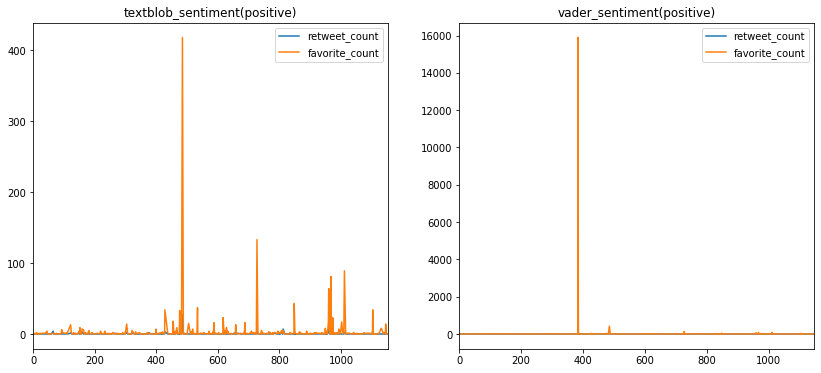

In [24]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(14,6))
tweet_data[tweet_data.textblob_sentiment=='Positive'].retweet_count.plot(ax=ax1)
tweet_data[tweet_data.textblob_sentiment=='Positive'].favorite_count.plot(ax=ax1)
ax1.title.set_text('textblob_sentiment(positive)')
ax1.legend(loc=0);
tweet_data[tweet_data.vader_sentiment=='Positive'].retweet_count.plot(ax=ax2)
tweet_data[tweet_data.vader_sentiment=='Positive'].favorite_count.plot(ax=ax2)
ax2.title.set_text('vader_sentiment(positive)')
ax2.legend(loc=0);

### Distribution of Positive tweets sentiment score

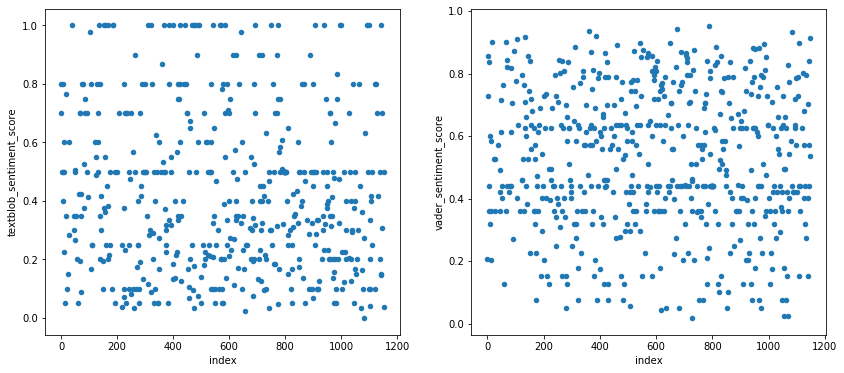

In [25]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(14,6))
tweet_data[tweet_data.textblob_sentiment=='Positive'].reset_index().plot.scatter('index','textblob_sentiment_score', ax=ax1);
tweet_data[tweet_data.vader_sentiment=='Positive'].reset_index().plot.scatter('index','vader_sentiment_score', ax=ax2);

## Analysis negative tweets

In this section we will do some Exploratory Data Analysis on negative tweets.

### Word cloud of negative tweets

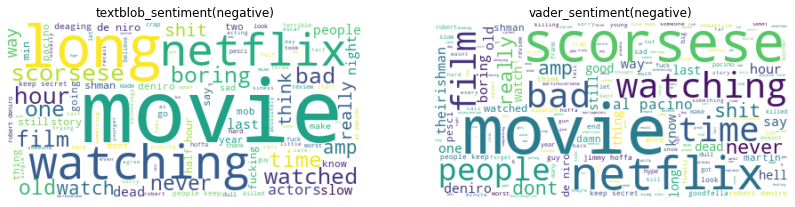

In [26]:
f, axarr = plt.subplots(1,2,figsize=(14,6))
ntweets= tweet_data[tweet_data.textblob_sentiment=='Negative'].text
wordcloud = WordCloud(background_color= 'white', colormap='viridis').generate(",".join(ntweets))
axarr[0].imshow(wordcloud, interpolation='bilinear')
axarr[0].axis("off")
axarr[0].title.set_text('textblob_sentiment(negative)')

ntweets= tweet_data[tweet_data.vader_sentiment=='Negative'].text
wordcloud = WordCloud(background_color= 'white', colormap='viridis').generate(",".join(ntweets))
axarr[1].imshow(wordcloud, interpolation='bilinear')
axarr[1].axis("off")
axarr[1].title.set_text('vader_sentiment(negative)')

### Retweet & Fav counts of negative tweets

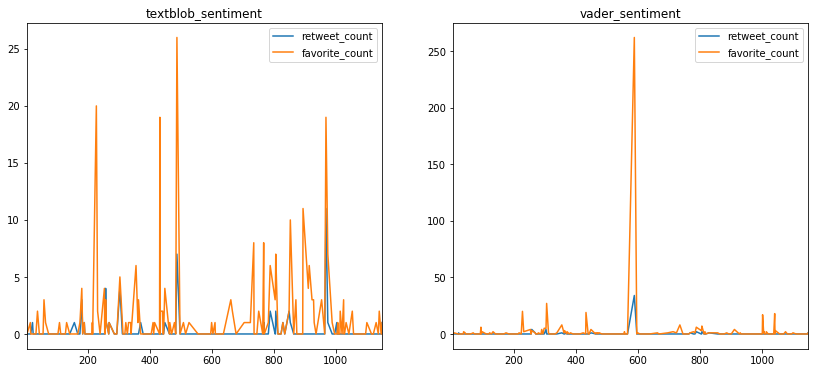

In [27]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(14,6))
tweet_data[tweet_data.textblob_sentiment=='Negative'].retweet_count.plot(ax=ax1)
tweet_data[tweet_data.textblob_sentiment=='Negative'].favorite_count.plot(ax=ax1)
ax1.title.set_text('textblob_sentiment')
ax1.legend(loc=0);

tweet_data[tweet_data.vader_sentiment=='Negative'].retweet_count.plot(ax=ax2)
tweet_data[tweet_data.vader_sentiment=='Negative'].favorite_count.plot(ax=ax2)
ax2.title.set_text('vader_sentiment')
ax2.legend(loc=0);

### Distribution of Negative tweets sentiment score

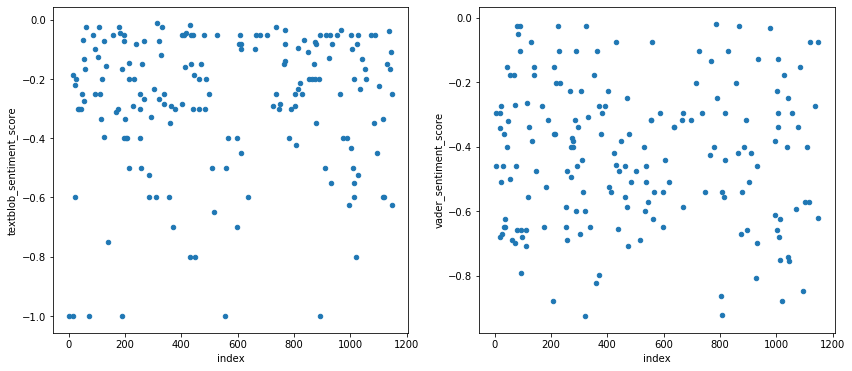

In [28]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(14,6))
ax2.set_ylabel('common ylabel')
tweet_data[tweet_data.textblob_sentiment=='Negative'].reset_index().plot.scatter('index','textblob_sentiment_score', ax=ax1);
tweet_data[tweet_data.vader_sentiment=='Negative'].reset_index().plot.scatter('index','vader_sentiment_score', ax=ax2);

## Collective sentiment analysis using TextBlob

In [29]:
blob = TextBlob(text)

print ("Sentiment Polarity for the collective tweets is as follows\n",blob.sentiment)

Sentiment Polarity for the collective tweets is as follows
 Sentiment(polarity=0.1796217827090465, subjectivity=0.5004790043290046)


### The distribution of words for higher impact in TextBlob analysis

In [30]:
(blob.sentiment_assessments.assessments)

[(['really', 'good'], 0.7, 0.6000000000000001, None),
 (['best'], 1.0, 0.3, None),
 (['killed'], -0.2, 0.0, None),
 (['great'], 0.8, 0.75, None),
 (['next'], 0.0, 0.0, None),
 (['welcome'], 0.8, 0.9, None),
 (['better'], 0.5, 0.5, None),
 (['loving'], 0.6, 0.95, None),
 (['sure'], 0.5, 0.8888888888888888, None),
 (['pretty'], 0.25, 1.0, None),
 (['much'], 0.2, 0.2, None),
 (['past'], -0.25, 0.25, None),
 (['full'], 0.35, 0.55, None),
 (['terrifying'], -1.0, 1.0, None),
 (['great'], 0.8, 0.75, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['last'], 0.0, 0.06666666666666667, None),
 (['good'], 0.7, 0.6000000000000001, None),
 (['angry'], -0.5, 1.0, None),
 (['major'], 0.0625, 0.5, None),
 (['dirty'], -0.6, 0.8, None),
 (['weird'], -0.5, 1.0, None),
 (['killed'], -0.2, 0.0, None),
 (['lmao'], 0.6, 1.0, None),
 (['several'], 0.0, 0.0, None),
 (['first'], 0.25, 0.3333333333333333, None),
 (['secret'], -0.4, 0.7, None),
 (['dead'], -0.2, 0.4, None),
 (['multiple', '!', '!', '!', '!'],

## Collective sentiment analysis using Vader

In [31]:
sia = SentimentIntensityAnalyzer()

In [32]:
print ("Sentiment score for the collective tweets using Vader is as follows\n", sia.polarity_scores(text))

Sentiment score for the collective tweets using Vader is as follows
 {'neg': 0.094, 'neu': 0.711, 'pos': 0.196, 'compound': 1.0}


## Conclusion

As we can see our individual tweet analysis provide a positive sentiment for the dataset.
When considering all tweets combined as a bag of word, we get a higher neutral sentiment analysis. The overall polarity of the text data is still positive. This gives us a good indication of viewability of the movie.

Based on our analysis, we would recommend this movie for any movie enthusiast
